<a href="https://colab.research.google.com/github/snufkin92/colab_tutorial/blob/master/section_08/simple_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# シンプルなRNNの実装
シンプルな再帰型ニューラルネットワーク（RNN）を用いて、時系列データを学習します。

## 訓練用データの作成
RNNに用いる訓練用のデータを作成します。  
サイン関数に乱数でノイズを加えたデータを作成し、過去の時系列データから未来の値を予測できるようにします。  
正解は、入力の時系列を一つ後にずらしたものにします。  

x_data shape = (50,)


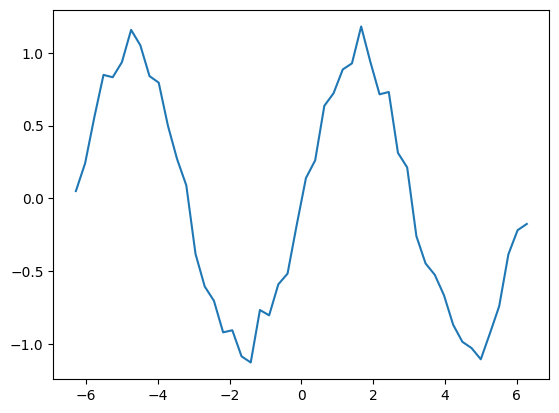

x shape = (40, 10)
(40, 10, 1)
[[0.04967142]
 [0.23982815]
 [0.55548641]
 [0.84798554]
 [0.83172743]
 [0.93525416]
 [1.1574075 ]
 [1.05167139]
 [0.83965187]
 [0.794534  ]]
値が１つだけずれているのが分かる。こういう時系列データが40個
[[0.23982815]
 [0.55548641]
 [0.84798554]
 [0.83172743]
 [0.93525416]
 [1.1574075 ]
 [1.05167139]
 [0.83965187]
 [0.794534  ]
 [0.49919313]]
(40, 10, 1)


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# -2πから2πまで、50個のデータを作成
x_data = np.linspace(-2*np.pi, 2*np.pi)
print(f"x_data shape = {x_data.shape}")

np.random.seed(42)  # 乱数のシードを固定
sin_data = np.sin(x_data)  + 0.1*np.random.randn(len(x_data))  # sin関数に乱数でノイズを加える

plt.plot(x_data, sin_data)
plt.show()

n_rnn = 10  # 時系列の数(0より右のデータは24-25個ある)
n_sample = len(x_data)-n_rnn  # サンプル数(40)

# n_sample行　n_rnn列のゼロを行列を作成
x = np.zeros((n_sample, n_rnn))  # 入力
t = np.zeros((n_sample, n_rnn))  # 正解
print(f"x shape = {x.shape}")

# i = 0からn_sample-1までの整数
for i in range(0, n_sample):

    # x＝iからi+10個のデータsin(x)データ
    x[i] = sin_data[i:i+n_rnn]

    # 予測したいのは x[i] の次に来る x[i+1] である為、時系列を入力よりも一つ後にずらす
    t[i] = sin_data[i+1:i+n_rnn+1]

x = x.reshape(n_sample, n_rnn, 1)  # KerasにおけるRNNでは、入力を（サンプル数、時系列の数、入力層のニューロン数）にする必要がある
print(x.shape)
print(x[0])
print("値が１つだけずれているのが分かる。こういう時系列データが40個")
print(x[1])
t = t.reshape(n_sample, n_rnn, 1)  # 今回は入力と同じ形状
print(t.shape)

sin波自体は単純な時系列データですが、これは例えば空気の振動である「音」を表していると考えることもできます。  
上記では、雑音の無いきれいな音にノイズを加えています。  
このようなsin波をニューラルネットワークで学習することができれば、これを例えば音声認識などに応用することも可能です。  
また、ノイズが混ざったsin波から真のsin波を抽出できれば、ノイズの除去が可能です。  
このように、今回扱う対象ははシンプルですが、現実社会で広く応用が可能することができます。

## RNNの構築
Kerasを使ってRNNを構築します。  
今回は、Kerasが持つRNNの中で一番シンプルなSimpleRNN層を使います。

### model.add(SimpleRNN(n_mid, input_shape=(n_rnn, n_in), return_sequences=True)) について

 １つの1つのSimpleRNN層の中に n_rnn＝10個のタイムステップを持つネットワークを作成、各タイムステップは同じ重みやバイアスを共有
 (共有するのでタイムステップが長いと勾配消失や勾配爆発が問題となる）


１つのタイムステップはn_mid=20個のニューロンを出力し、同じくn_mid個の隠し状態を作成する（隠れ状態の値は対応する出力ニューロン毎に異なる）

SimpleRNN層の追加。return_sequenceをTrueにすると、全てのタイムステップから隠れ
状態が参照できる。

return_sequences=True の場合、出力は (タイムステップ数, 隠れ状態の次元)となる

return_sequenceをFalseにすると、最後の隠れ状態のみ各タイムステップは参照でき、出力は（最後の隠れ状態の次元）

各タイムステップの入力は、[0.04967142] や [0.23982815] などの1次元配列

#### １番目のタイムステップの処理詳細
初期隠れ状態 (通常はゼロベクトル) と [0.04967142] を入力として、次の値 (ここでは [0.23982815] に対応する値) を予測

#### ２番目のタイムステップの処理詳細
１番目のタイムステップの隠れ状態と [0.23982815] を入力として、次の値 (ここでは [0.55548641] に対応する値) を予測



In [2]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

batch_size = 8  # バッチサイズ
n_in = 1  # 入力層のニューロン数：sin(x[i]) に相当
n_mid = 20  # 中間層のニューロン数
n_out = 1  # 出力層のニューロン数：sin(x[i+1]) に相当

model = Sequential()

# １つの1つのSimpleRNN層の中に n_rnn＝10個のタイムステップを持つネットワークを作成、各タイムステップは同じ重みやバイアスを共有
# １つのタイムステップはn_mid=20個のニューロンを出力し、同じくn_mid個の隠し状態を作成する（隠れ状態の値は対応する出力ニューロン毎に異なる）
# SimpleRNN層の追加。return_sequenceをTrueにすると、全てのタイムステップから隠れ状態が参照できる。
# return_sequences=True の場合、出力は (タイムステップ数, 隠れ状態の次元)となる
# return_sequenceをTrueをFalseにすると、最後の隠れ状態のみ各タイムステップは参照でき、出力は（最後の隠れ状態の次元）
# 各タイムステップの入力は、[0.04967142] や [0.23982815] などの1次元配列
# １番目のタイムステップは、期隠れ状態 (通常はゼロベクトル) と [0.04967142] を入力として、次の値 (ここでは [0.23982815] に対応する値) を予測
model.add(SimpleRNN(n_mid, input_shape=(n_rnn, n_in), return_sequences=True))

# SimpleRNN層を経て、隠れ状態のシーケンス（n_rnn, n_mid) を出力し、sin(x[i+1])の期待値を出力
model.add(Dense(n_out, activation="linear"))
model.compile(loss="mean_squared_error", optimizer="sgd")  # 誤差は二乗誤差、最適化アルゴリズムはSGD
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10, 20)            440       
                                                                 
 dense (Dense)               (None, 10, 1)             21        
                                                                 
Total params: 461 (1.80 KB)
Trainable params: 461 (1.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## バッチサイズについて
今回（sin関数）は、バッチサイズが8の場合、8個の入力シーケンスが同時に処理されますが、それぞれのシーケンスの 最初のタイムステップの初期隠れ状態はゼロベクトル になります。

今回はタイムステップ感の連続性だけを考慮すれば良い為、バッチ間をシャッフルしても良いが、文章などの場合は別。
バッチ間の連続性も考慮する必要があり、更にRNNの初期隠れ状態も前のバッチの影響を考慮すべき。そのようなRNNをステートフルRNNと呼ぶ

一般的なLSTMやGRUはバッチ間の連続性は考慮されておらずステートレスRNN（ステートレスにすることも可能）

## 学習
構築したRNNのモデルを使って、学習を行います。  

In [3]:
history = model.fit(x, t, epochs=20, batch_size=batch_size, validation_split=0.1)

Epoch 1/20
5/5 [==============================] - 2s 83ms/step - loss: 0.3670 - val_loss: 0.1106
Epoch 2/20
5/5 [==============================] - 0s 15ms/step - loss: 0.1929 - val_loss: 0.0788
Epoch 3/20
5/5 [==============================] - 0s 13ms/step - loss: 0.1332 - val_loss: 0.0650
Epoch 4/20
5/5 [==============================] - 0s 14ms/step - loss: 0.1024 - val_loss: 0.0566
Epoch 5/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0843 - val_loss: 0.0525
Epoch 6/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0735 - val_loss: 0.0487
Epoch 7/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0673 - val_loss: 0.0446
Epoch 8/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0630 - val_loss: 0.0436
Epoch 9/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0601 - val_loss: 0.0403
Epoch 10/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0581 - val_loss: 0.0413
Epoch 11/20
5/5 [============

## 学習の推移
誤差の推移を確認します。

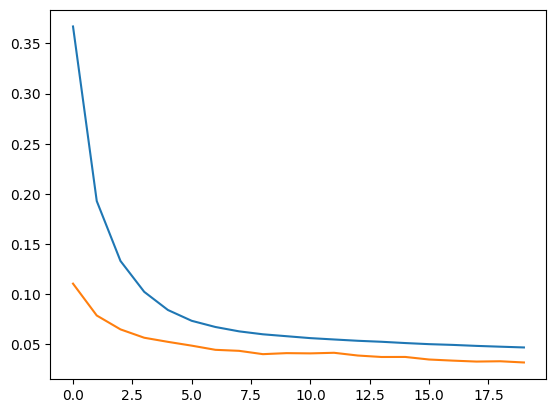

In [4]:
loss = history.history['loss']
vloss = history.history['val_loss']

plt.plot(np.arange(len(loss)), loss)
plt.plot(np.arange(len(vloss)), vloss)
plt.show()

## 学習済みモデルの使用
RNNの学習済みモデルを使って、サイン関数の次の値を予測します。

In [5]:
predicted = x[0].reshape(-1)
print(predicted)

# モデルにタイムステップとして渡せるように変換
predicted[-n_rnn:].reshape(1, n_rnn, 1)

[0.04967142 0.23982815 0.55548641 0.84798554 0.83172743 0.93525416
 1.1574075  1.05167139 0.83965187 0.794534  ]


array([[[0.04967142],
        [0.23982815],
        [0.55548641],
        [0.84798554],
        [0.83172743],
        [0.93525416],
        [1.1574075 ],
        [1.05167139],
        [0.83965187],
        [0.794534  ]]])

1/1 [==============================] - 0s 22ms/step


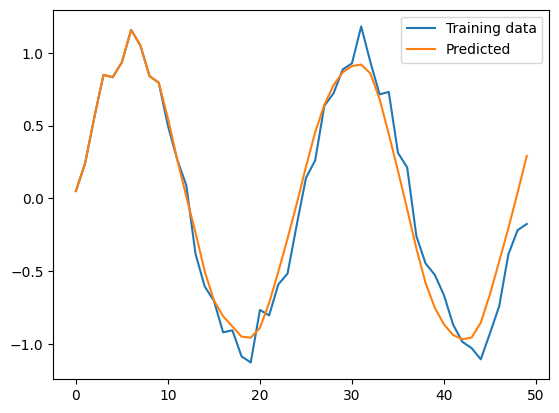

In [8]:
predicted = x[0].reshape(-1)  # 最初の入力。reshape(-1)で一次元のベクトルにする。

# 0から39までの整数でループ
for i in range(0, n_sample):

    # [0.794534  ]の次の値をyとして予測
    # predictedは予測値を最後にappendし、どんどんサイズが大きくなっていくが、予測の入力は常にpredictedの後方からn_rnn個の要素を使っている
    # 即ち予測値を使って予測しているため、どんどんズレていく可能性がある
    y = model.predict(predicted[-n_rnn:].reshape(1, n_rnn, 1))  # 直近のデータを使って予測を行う
    predicted = np.append(predicted, y[0][n_rnn-1][0])  # 出力の最後の結果をpredictedに追加する

plt.plot(np.arange(len(sin_data)), sin_data, label="Training data")
plt.plot(np.arange(len(predicted)), predicted, label="Predicted")
plt.legend()
plt.show()

直近の時系列データを使って、次の値を予測できるようになりました。  
今回はサインカーブの予測を行いましたが、同様の技術を例えば価格の予測などに応用することも可能です。